In [1]:
# Disable reloading to prevent unnecessary numba recompilation
%load_ext autoreload
%autoreload 2

In [2]:
from neurkal.neurkal import _calc_activity
import neurkal
import neurkal.utils as utils

import cProfile
import itertools
from os import environ
import pstats

#import ipympl
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#from mpl_toolkits.mplot3d import Axes3D
import numba as nb
import numpy as np
from scipy.misc import derivative
import seaborn as sns

In [81]:
%load_ext line_profiler

In [3]:
%matplotlib inline

# make Numpy raise warnings as exceptions (or not)
np.seterr(all='warn')
#np.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [4]:
## Plot style setup
sns.set_style("ticks", {'font_scale': 1.5})
set_palette = lambda: itertools.cycle(sns.color_palette('deep'))
#sns.set(font_scale=1.5)

In [194]:
# dynamical parameters
M = [[1]]  # internal model dynamics
B = [[0.003]]   # constant "motor" dynamics
Z = [[0.001]]  # motor noise variance
c = np.array([[1]])

In [219]:
# simulation parameters
p = 30  # units in input networks
th_r = [-180, 180]
d_th = [20, 30]
#steps = int(np.diff(d_th) / B[0][0])  # number of timesteps
steps = 15000
t_f = 100
ts = np.linspace(0, t_f, steps)

In [196]:
K_w = 3
mu = 0.001
eta = 0.01

In [205]:
def input_act(x, prefs):
    act = 3 * (np.exp(2 * (np.cos(np.deg2rad(x - prefs)) - 1)) + 0.01)
    return act

In [220]:
## initial state and network setup
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

change = True
dx_change = 25

prior = True
x_prior = 0.0

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

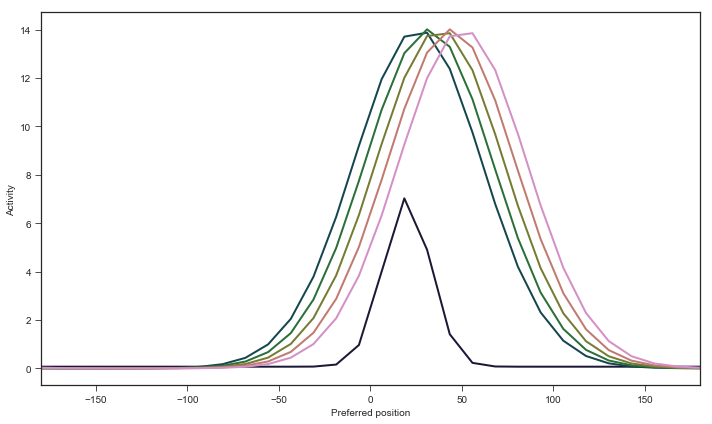

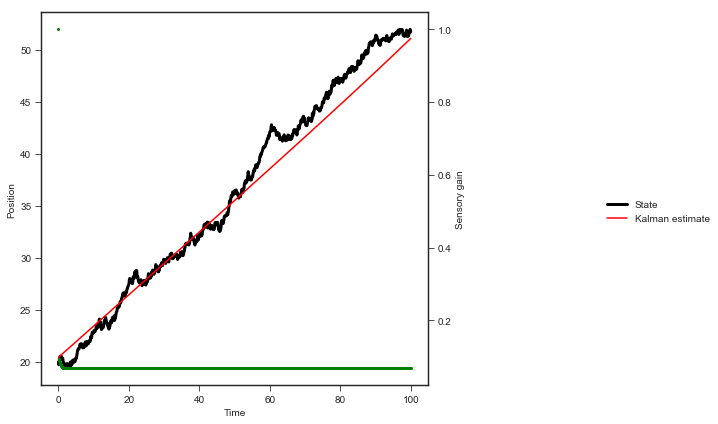

In [10]:
## Kalman network test -- only initial feedback
inputs = []
activities = []
states = []
estimates = []
gains = []

sensory_input(state.x[0], certain=True)

for i, t in enumerate(ts):
    inputs.append(np.copy(sensory_input.activity))
    states.append(state.x[0])
    gains.append(kalman_network.lam[0])
    # update activity in basis network implementing Kalman filter
    kalman_network.update()
    estimates.append(kalman_network.estimate)
    activities.append(kalman_network.activity)
    
    # update real state (+ control noise)
    state.update(c)
    if not t:
        sensory_input.clear()

prefs = kalman_network.prefs

# plot of network activity over time
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn1.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 6
ps = []
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
#ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(0, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
#labels = [p.get_label() for p in ps]
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

# plot of estimates and sensory gains over time
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
#ax2.set_ylim([0, 1])
p3, = ax2.plot(ts, gains, '.', color='g', label="Sensory gain", ms=4)

ps = [p1, p2]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

In [221]:
## Kalman network test: state estimates at each timestep
states = []
inputs = []
activities = []
estimates = []
meas = []
gains = []

weird_ros = []

def iterate_network(ts_):
    for i, t in enumerate(ts_):
        if prior and not i:
            sensory_input(np.array([x_prior]))  # prior
            kalman_network.update(first=True)
        else:
            sensory_input(state.x[0])
            kalman_network.update()
        states.append(state.x[0])
        inputs.append(sensory_input.activity)
        activities.append(kalman_network.activity)
        estimates.append(kalman_network.estimate)
        gains.append(kalman_network.lam[0])
        meas.append(sensory_input.readout())
        #if meas[-1] - state.x[0] > 40:
        #    weird_ros.append([state.x[0], sensory_input.activity])

        # update real state (+ control noise)
        if change and i == int(0.5 * steps):
            state.change(state.x - dx_change)
        state.update(c)

cProfile.run('iterate_network(ts)', 'kalnet_stats_numba')

In [184]:
# profile kalman_network.update line-by-line
sensory_input(state.x[0])
%lprun -T kalnet_linestats_update -f kalman_network.update kalman_network.update()


*** Profile printout saved to text file 'kalnet_linestats_update'. 


Timer unit: 1e-06 s

Total time: 0.00102 s
File: /home/mll/dev/neural-kalman/neurkal/neurkal.py
Function: update at line 222

Line #      Hits         Time  Per Hit   % Time  Line Contents
   222                                               def update(self, estimate=True, first=False):
   223                                                   """
   224                                                   TODO:
   225                                                       * Pass new state vector
   226                                                   """
   227                                                   # update activation function
   228        16         28.0      1.8      2.7          self._h = _calc_h(self._w, self._activity,
   229        16         95.0      5.9      9.3                            self._mu, self._eta)
   230                                           
   231                                                   # calculate new activities
   232        16         2

In [ ]:
%lprun -T kalnet_linestats_numba -f iterate_network iterate_network(ts)

In [217]:
ps = pstats.Stats('kalnet_stats_numba')
ps.sort_stats('tottime')
ps.print_stats(25)

Sun May  6 11:27:57 2018    kalnet_stats_numba

         9420006 function calls (9120006 primitive calls) in 27.282 seconds

   Ordered by: internal time
   List reduced from 163 to 25 due to restriction <25>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
320000/20000    7.576    0.000   11.903    0.001 /home/mll/dev/neural-kalman/neurkal/neurkal.py:222(update)
    20000    1.142    0.000   10.796    0.001 /home/mll/dev/neural-kalman/neurkal/neurkal.py:270(readout)
    20000    1.138    0.000    1.138    0.000 /home/mll/dev/neural-kalman/neurkal/utils.py:11(filt)
   300000    0.949    0.000    1.710    0.000 /home/mll/dev/neural-kalman/neurkal/neurkal.py:155(step)
   320000    0.926    0.000    0.926    0.000 /home/mll/dev/neural-kalman/neurkal/neurkal.py:314(_calc_h)
   320000    0.829    0.000    0.829    0.000 /home/mll/dev/neural-kalman/neurkal/neurkal.py:349(_calc_activity)
   300000    0.761    0.000    0.761    0.000 /home/mll/dev/neural-kalman/neurkal/

In [ ]:
ps.print_callers(25)

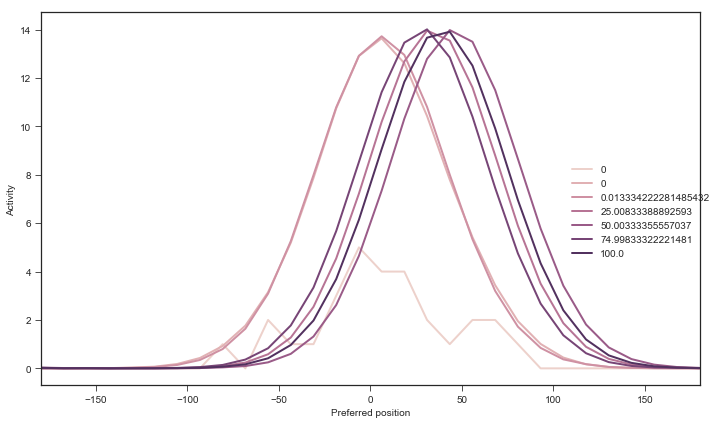

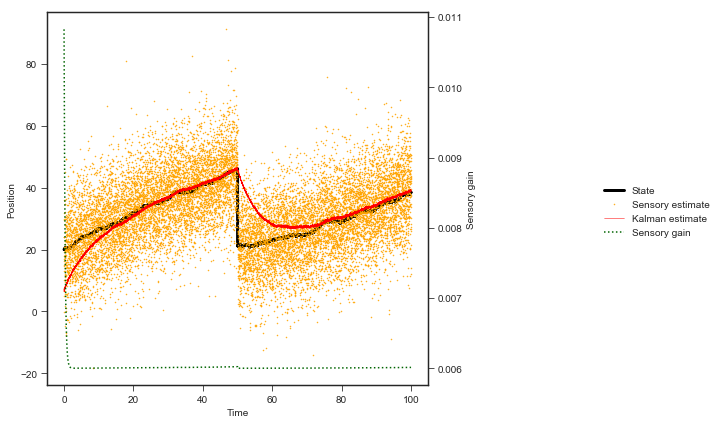

In [222]:
prefs = kalman_network.prefs

# plot of network activity over time
palette = itertools.cycle(sns.cubehelix_palette(8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn1.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
ps.append(ax1.plot(prefs, activities[1], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(2, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

# plot of estimates and sensory gains over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
#ax1.set_ylim([-40, 60])
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p4, = ax1.plot(ts, meas, '.', color='orange', label="Sensory estimate", ms=1) 
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=0.5)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
#ax2.set_ylim([0, 1])
p3, = ax2.plot(ts, gains, ':', color='darkgreen', label="Sensory gain", ms=5)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

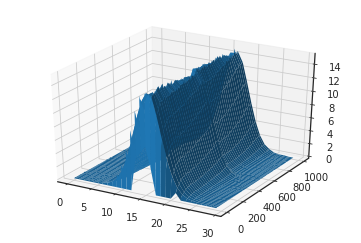

In [15]:
plot_step = 5
fig = plt.figure()
ax = fig.gca(projection='3d')
prefs_, ts_ = np.meshgrid(range(p), range(0, steps, plot_step))
act = np.array(activities)[::plot_step]
surf = ax.plot_surface(prefs_, ts_, act, linewidth=0)
plt.show()

Testing D=2 behaviour, and debugging vectorization of _calc_activity:

In [45]:
# dynamical parameters
M = np.eye(2)  # internal model dynamics
B = [[0.03], [0.03]]   # constant "motor" dynamics
Z = 0.02*np.eye(2)  # motor noise variance
c = np.array([[1]])

In [56]:
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
sensory_input(15)
a = np.copy(sensory_input.activity)
sensory_input(150)
b = np.copy(sensory_input.activity)
inp_acts = np.vstack([a, b])
print(inp_acts)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  3.  7.  8.  2.
   2.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  5. 10.  1.  0.]]


In [48]:
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input] * 2, 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

In [ ]:
## Kalman network: simple profiling (no readout)
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

def iterate_network(ts_):
    for i, t in enumerate(ts_):
        sensory_input(state.x[0])
        kalman_network.update()
        state.update(c)
    
cProfile.run('iterate_network(ts)', 'kalnet_stats_numba')

In [ ]:
ps = pstats.Stats('kalnet_stats_numba')
ps.sort_stats('tottime').print_stats(25)

In [21]:
## tmp tests
# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

sensory_input(np.array([15]))

f_c = np.ones(p)

In [24]:
_calc_activity(p, kalman_network._idx, np.array([sensory_input.activity]), kalman_network._h, f_c, kalman_network._lambda, kalman_network._d)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 5., 5., 9.,
       4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [35]:
def calc_activity(N, idxs, input_activities, h, f_c, lambda_, d):
    act = np.zeros(N, dtype=np.float64)
    n = np.arange(N)
    idx = idxs[n][:, d]
    S_d = np.ravel(input_activities[:, idx])
    print(S_d)
    act = np.dot(h, f_c) + np.dot(lambda_, S_d)
    return act
calc_activity(p, kalman_network._idx, np.array([sensory_input.activity]), kalman_network._h, f_c, kalman_network._lambda, kalman_network._d)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 5. 5. 9. 4. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


ValueError: shapes (1,1) and (30,) not aligned: 1 (dim 1) != 30 (dim 0)

In [15]:
# testing different input tuning functions
## Kalman network test: state estimates at each timestep
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

change = True
dx_change = 25

prior = True
x_prior = 0.0

# network initialization
sensory_input = neurkal.PopCode(p, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input], 
                                            motor_inputs=[], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

states = []
inputs = []
activities = []
estimates = []
meas = []
gains = []

weird_ros = []

for i, t in enumerate(ts):
    if prior and not i:
        sensory_input(np.array([x_prior]))  # prior
        kalman_network.update(first=True)
    else:
        sensory_input(state.x[0])
        kalman_network.update()
    states.append(state.x[0])
    inputs.append(sensory_input.activity)
    # update activity in basis network implementing Kalman filter
    #print(sensory_input.cr_bound)
    activities.append(kalman_network.activity)
    estimates.append(kalman_network.estimate)
    gains.append(kalman_network.lam[0])
    meas.append(sensory_input.readout())
    if meas[-1] - state.x[0] > 40:
        weird_ros.append([state.x[0], sensory_input.activity])
    
    # update real state (+ control noise)
    if change and i == int(0.5 * steps):
        state.change(state.x - dx_change)
    state.update(c)

In [130]:
weird_ros

[]

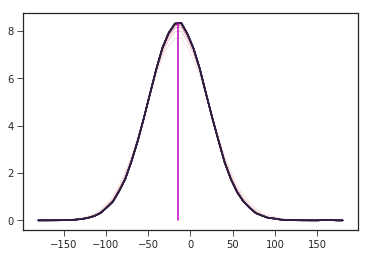

In [54]:
# test readout convergence
its = 15
ro = kalman_network.readout(iterations=its)
p_palette = itertools.cycle(sns.cubehelix_palette(its))
for i in range(its):
    plt.plot(kalman_network.prefs, kalman_network.readout_activity[i], color=next(p_palette), lw=np.sqrt(i/5))
plt.plot([ro] * 2, [0, np.max(kalman_network.readout_activity[-1])], 'm')
plt.show()

In [550]:
# Cramer-Rao bound
x = 3
sensory_input = neurkal.PopCode(200, space=th_r, act_func=input_act,
                                dist=np.random.poisson)
prefs = sensory_input.prefs
act_f = sensory_input.act_func
sensory_input(x)
fs = [(lambda x_i: (lambda x_: act_f(x_, x_i)))(x_i)
              for x_i in prefs]
dx_f = np.array([derivative(f, x, dx=dx) for f in fs]).T
q = 1 / (dx_f @ np.linalg.inv(np.diag(sensory_input.mean_activity)) @ dx_f.T)
q

13.331207835625696

In [510]:
sensory_input.cr_bound

array([[54.13240554]])

In [ ]:
prefs = sensory_input.prefs

# plot of network activity over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn3.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
#ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(0, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, inputs[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
labels = [p.get_label() for p in ps]
#fig.legend(ps, labels, loc=7)
fig.tight_layout()
#fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()


In [574]:
# dynamical parameters
M = [[1, 0.5],
     [0, 0.9]]  # internal model dynamics
B = [[0],
     [1]]   # constant "motor" dynamics
Z = [[0.001, 0],
     [0, 0.001]]  # motor noise variance
c = np.array([[0],
              [1]])

In [575]:
# simulation parameters
p = 20  # units in input networks
th_r = [-180, 180]
d_th = [20, 30]
#steps = int(np.diff(d_th) / B[0][0])  # number of timesteps
steps = 100
t_f = 100
ts = np.linspace(0, t_f, steps)

In [576]:
K_w = 3
mu = 0.001
eta = 0.005

In [577]:
def input_act(x, x_i):
    return 3 * (np.exp(2 * (np.cos(np.deg2rad(x - x_i)) - 1)) + 0.01)

In [584]:
## Kalman network test: 1D arm position
# initial state
state = neurkal.StateDynamics(M, B, Z, x0=d_th[0])

dx_change = [[50], [0]]

# network initialization
sensory_inputs = [neurkal.PopCode(p, space=th_r, act_func=input_act, dist=np.random.poisson),
                  neurkal.PopCode(p, space=th_r, act_func=input_act, dist=np.random.poisson)]
motor_input = neurkal.PopCode(p, space=th_r, act_func=input_act, dist=lambda x: x)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=sensory_inputs, 
                                            motor_inputs=[motor_input], M=M, B=np.array(B), Z=Z,
                                            mu=mu, eta=eta, K_w=K_w)

states = []
activities = []
estimates = []
meas = []
gains = []


for i, t in enumerate(ts):
    if i:
        sensory_input(state.x[0])
        kalman_network.update()
    else:
        sensory_input(np.array([0.0]))  # prior
        kalman_network.update(first=True)
    states.append(state.x[0])
    # update activity in basis network implementing Kalman filter
    #sigma = np.var(estimates[-10:]) if i > 10 else 1e12
    
    activities.append(kalman_network.activity)
    estimates.append(kalman_network.estimate)
    gains.append(kalman_network.lam[0])
    meas.append(sensory_input.readout())
    
    # update real state (+ control noise)
    if i == int(0.5 * steps):
        state.change(state.x - dx_change)
    state.update(c)
    
    
prefs = kalman_network.prefs

# plot of network activity over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn1.pdf')
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
plots = 5
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label="0")[0])
for i in np.linspace(1, len(ts) - 1, plots).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, 
                       label=str(ts[int(i)]))[0])
#ps.append(ax1.plot(prefs, activities[-1], '-', color=next(palette), lw=2, label=str(ts[-1]))[0])
ax1.set_xlim(*th_r)
#ax1.set_ylim([0, 1])
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

# plot of estimates and sensory gains over time
palette = itertools.cycle(sns.color_palette("cubehelix", 8))
fig, ax1 = plt.subplots(figsize=(10, 6))
pp = PdfPages('kn2.pdf')
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color='k', label="State", lw=3)
p2, = ax1.plot(ts, estimates, '-', color='r', label="Kalman estimate", markerfacecolor='none', lw=2)
p4, = ax1.plot(ts, meas, '.', color='y', label="Measurement", ms=8) 
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
ax2.set_ylim([0, 1])
p3, = ax2.plot(ts, gains, '.', color='g', label="Sensory gain", ms=5)

ps = [p1, p4, p2, p3]
labels = [p.get_label() for p in ps]
fig.legend(ps, labels, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.6)   
plt.show()
pp.savefig(fig)
pp.close()

ValueError: setting an array element with a sequence.